In [192]:
# torch_geometric
import torch_geometric
import torch_geometric.nn as gnn
import torch_geometric.data as gd

# torch
import torch
from torch import nn
import torch.nn.functional as F

# rdkit
import rdkit
from rdkit import Chem

# ML related
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import tqdm


# custom library
import mol_env as env
from models import MLP, RGCN
from distributions import ActionCategorical

# check version
print("torch_geometric\t", torch_geometric.__version__)
print("torch\t", torch.__version__)
print("pandas\t", pd.__version__)
print("rdkit\t", rdkit.__version__)
print("matplotlib\t", matplotlib.__version__)
print("tqdm\t", tqdm.__version__)
print("networkx\t", nx.__version__)

torch_geometric	 2.3.1
torch	 2.0.1
pandas	 2.1.1
rdkit	 2023.03.3
matplotlib	 3.8.0
tqdm	 4.66.1
networkx	 3.1


# Define a Model

We extract node- and graph-level features using GCN. Then we compute logit values for each action.

- Stop: calculated based on graph features.
- AddNode: calculated based on graph features.
- AddEdge: calculated based on two node features to be connected (similar to link prediction).

In [2]:

class Policy(nn.Module):
    def __init__(self, num_node_types, num_edge_types, emb_dim=32, num_layers=3, activation="leaky_relu"):
        super().__init__()
        self.num_node_types = num_node_types
        self.num_edge_types = num_edge_types
        self.graph_nn = RGCN(num_node_types, num_edge_types, emb_dim=emb_dim, num_layers=num_layers)
        self.stop_mlp = MLP([emb_dim, emb_dim, 1], activation)
        self.addnode_mlp = MLP([emb_dim, emb_dim, num_node_types], activation)
        self.addedge_mlp = MLP([emb_dim, emb_dim, emb_dim, num_edge_types], activation)
        self.activation = getattr(F, activation)
        
    def logits(self, g):
        x = self.graph_nn(g)
        graph_features = gnn.global_add_pool(x, g.batch)
        
        i, j = g.non_edge_index
        non_edge_features = x[i] + x[j]
        
        stop_logits = self.stop_mlp(graph_features).flatten()
        addnode_logits = self.addnode_mlp(graph_features).flatten() 
        addedge_logits = self.addedge_mlp(non_edge_features).flatten()
        logits = [stop_logits, addnode_logits, addedge_logits]
        return torch.cat(logits, dim=0)
    
    def forward(self, states):
        g = self.collate(states)
        logits = self.logits(g)
        stop_batch = torch.arange(g.num_graphs)
        addnode_batch = torch.arange(g.num_graphs).repeat_interleave(self.num_node_types)
        addedge_batch = torch.repeat_interleave(self.num_edge_types * g.num_non_edges)
        indices = torch.cat([stop_batch, addnode_batch, addedge_batch], dim=0)
        return ActionCategorical(states, logits, indices)
    
    def collate(self, states):
        return gd.Batch.from_data_list(
            [env.to_Data(s) for s in states]
        )

        
        
# sample data
caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
state = env.State.from_smiles(caffeine)
traj = env.get_bfs_trajectory(state)


# Model
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=32, num_layers=3)
cat = model(traj.states)
cat

ActionCategorical(size=29)

In [4]:
cat.log_prob(traj.actions)

tensor([ -2.4442,  -2.7075,  -2.5722,  -2.8552,  -3.4012,  -3.0843,  -3.3883,
         -3.8011,  -4.1866,  -4.0660,  -4.2265,  -4.2201,  -4.1138,  -4.5701,
         -4.7693,  -6.5081,  -5.1335,  -6.0265,  -5.2454,  -3.5483,  -5.3969,
         -4.0391,  -5.5428,  -5.8665,  -5.2632,  -6.1691, -10.0930,  -6.6618,
        -12.4662], grad_fn=<IndexBackward0>)

# Sampler

In [329]:
@torch.no_grad()
def sample_trajectory(env, model, max_len=25):
    model.eval()
    states, actions = [], []
    state = env.initial_state()
    for _ in range(max_len):
        cat = model([state])
        action = cat.sample()[0]
        next_state, done = env.step(state, action)
        
        states.append(state)
        actions.append(action)
        
        state = next_state
        if done:
            break
            
    return env.Trajectory(states, actions)


def sample_trajectories(env, model, n_samples, max_len=25):
    not_done = np.ones(n_samples, dtype=bool)
    states = [env.initial_state() for _ in range(n_samples)]
    trajectories = [[] for _ in range(n_samples)]
    for _ in range(max_len):
        actions = model(states).sample()
        nz = not_done.nonzero()[0]
        next_states = []
        for i, state, action in zip(nz, states, actions):
            next_state, done = env.step(state, action)
            
            if not done:
                next_states.append(next_state)
            else:
                not_done[i] = False

            trajectories[i].extend([state, action])

        if any(not_done):
            states = next_states
        else:
            break
            
    trajectories = [env.Trajectory(t[::2], t[1::2]) for t in trajectories]
    return trajectories

trajs = sample_trajectories(env, model, n_samples=3)
trajs

[Trajectory(size: 25), Trajectory(size: 1), Trajectory(size: 22)]

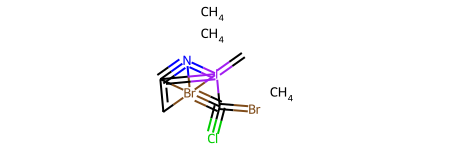

In [330]:
trajs[0].last_state.to_mol()

# Maximum-likelihood Training

In [60]:
url = 'https://raw.githubusercontent.com/gashawmg/HOMO-LUMO-Enegry-gap-Prediction/master/Orbital_Energies_input_data.csv'
dataset = pd.read_csv(url)
molecules = dataset.SMILES.apply(Chem.MolFromSmiles).tolist()

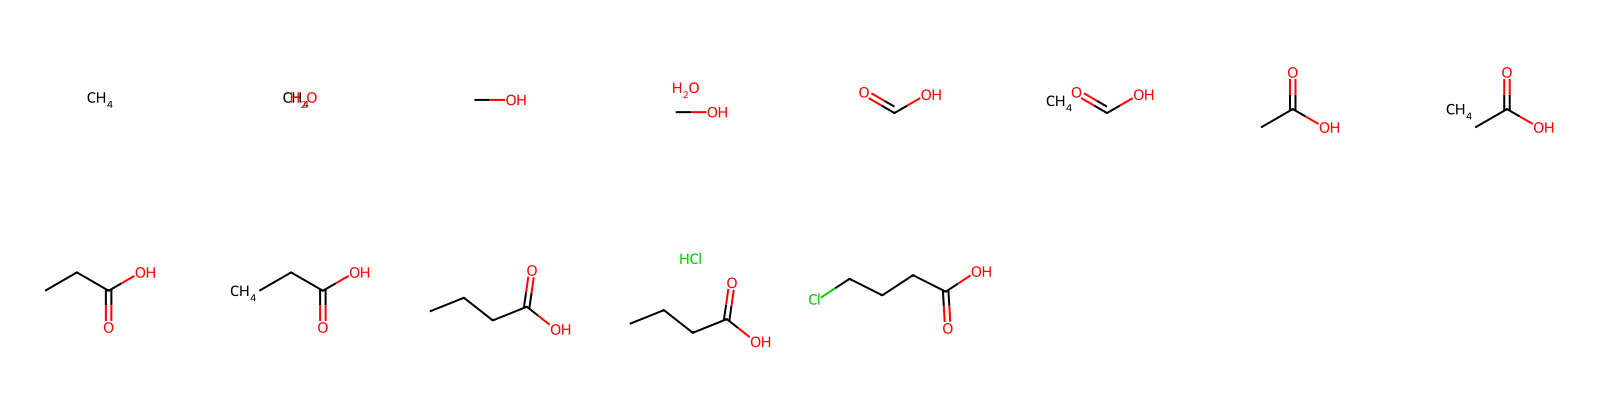

In [318]:
# We will use only two samples to see if this works

mol_state0 = env.State.from_mol(molecules[0])
mol_state1 = env.State.from_mol(molecules[1])
traj0 = env.get_bfs_trajectory(mol_state0)
traj1 = env.get_bfs_trajectory(mol_state1)

states = traj0.states + traj1.states
actions = traj0.actions + traj1.actions

Chem.Draw.MolsToGridImage([s.to_mol() for s in traj1.states], molsPerRow=8)

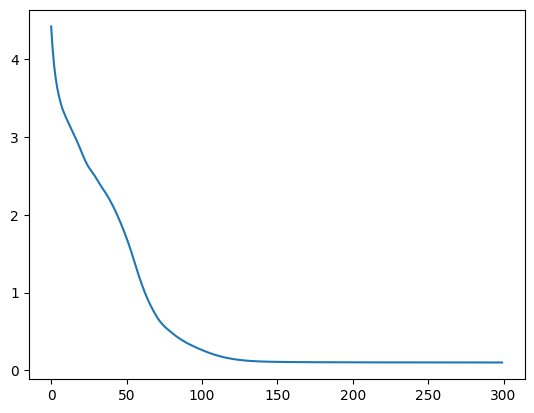

In [319]:
# overfit
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=32, num_layers=3)
optimizer = torch.optim.Adam(model.parameters())

losses = []
for _ in range(300):
    cat = model(states)
    loss = -cat.log_prob(actions).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    
plt.plot(losses)
plt.show()

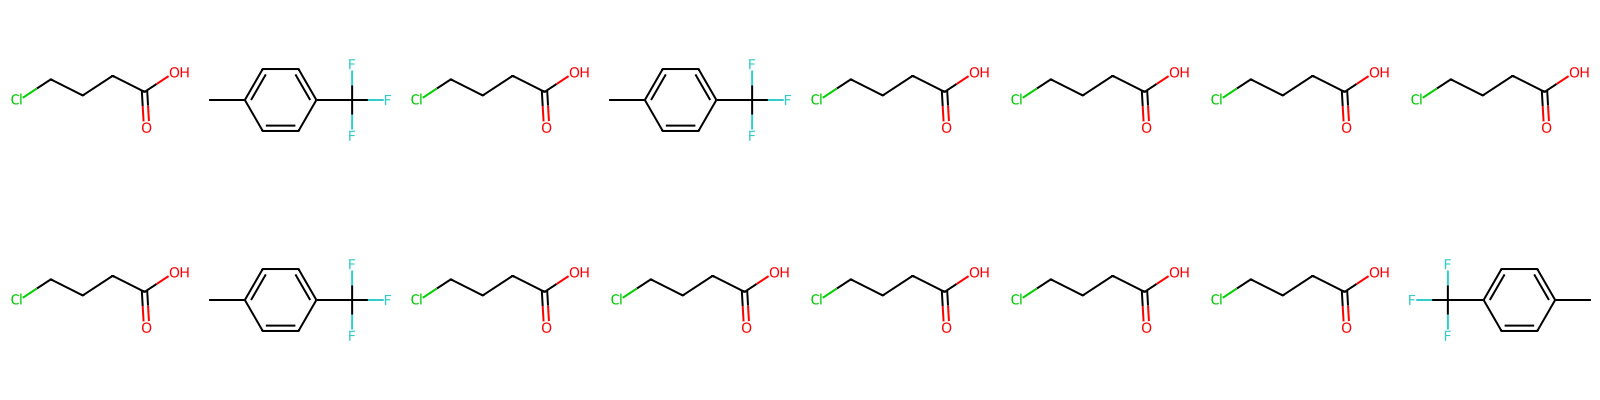

In [320]:

trajs = sample_trajectories(env, model, n_samples=16)
samples = [t.last_state.to_mol() for t in trajs]
    
Chem.Draw.MolsToGridImage(samples, molsPerRow=8)

In [ ]:
# preprocess data
all_states = []
for m in molecules:
    try:
        all_states += [env.State.from_mol(m)]
    except:
        pass

100%|███████████████████████████████| 200/200 [00:19<00:00, 10.06it/s, loss=0.868]


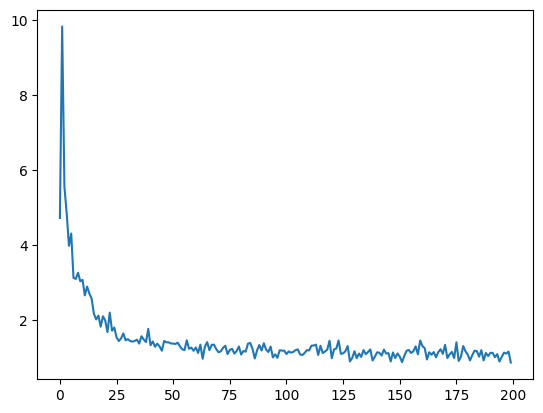

In [321]:
# train on full data

batch_size = 16
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters())

losses = []
pbar = tqdm.trange(200)
for _ in pbar:
    minibatch = np.random.choice(all_states, size=batch_size)
    trajs = [env.get_bfs_trajectory(s) for s in minibatch]

    states = sum([t.states for t in trajs], [])
    actions = sum([t.actions for t in trajs], [])
    
    cat = model(states)
    loss = -cat.log_prob(actions).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    pbar.set_postfix({"loss":loss.item()})
    
    
plt.plot(losses)
plt.show()

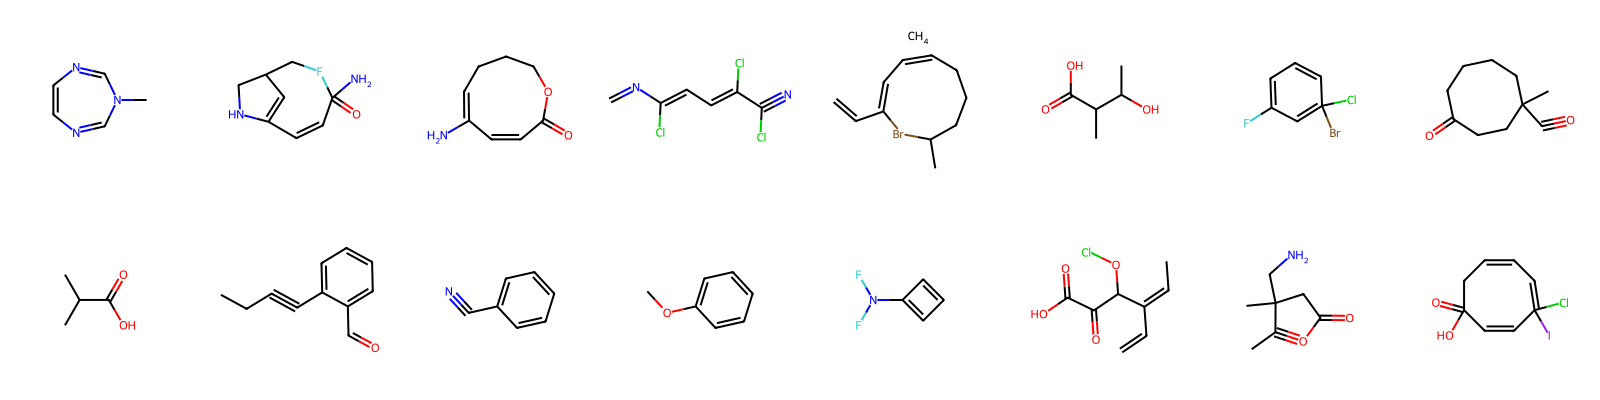

In [322]:

trajs = sample_trajectories(env, model, n_samples=16)
samples = [t.last_state.to_mol() for t in trajs]
    
Chem.Draw.MolsToGridImage(samples, molsPerRow=8)

# REINFORCE


In [323]:
def reward_func(state):
    reward = 0.0

    # +0.5 for oxygen
    for u in state.node_types:
        if u == env.NodeType.O:
            reward += 0.5

    # -0.2 for SINGLE
    # -0.4 for DOUBLE, -0.6 for TRIPLE bond
    for e in state.edge_types:
        reward -= 0.2 * e.value 

    # -1 reward for connected components
    G = nx.from_edgelist(state.edge_list)
    G.add_nodes_from(np.arange(len(state.node_types)))
    reward -= nx.number_connected_components(G)            
    return reward


traj = sample_trajectory(env, model)
reward_func(traj.last_state)

-3.1999999999999997

In [324]:
def get_trajectory_log_probs(model, trajectories):    
    model.train()
    states = sum([t.states for t in trajectories], [])
    actions = sum([t.actions for t in trajectories], [])
    state_log_probs = model(states).log_prob(actions)

    sizes = torch.LongTensor([len(t) for t in trajectories])
    batch = torch.repeat_interleave(sizes)
    traj_log_probs = gnn.global_add_pool(state_log_probs, batch)
    return traj_log_probs

trajectories = sample_trajectories(env, model, n_samples=5)
get_trajectory_log_probs(model, trajectories) 

tensor([-17.4064, -16.5894, -17.4662, -11.8478, -28.6176],
       grad_fn=<ScatterAddBackward0>)

100%|███████████████████████████| 300/300 [00:13<00:00, 22.54it/s, avg_reward=2.6]


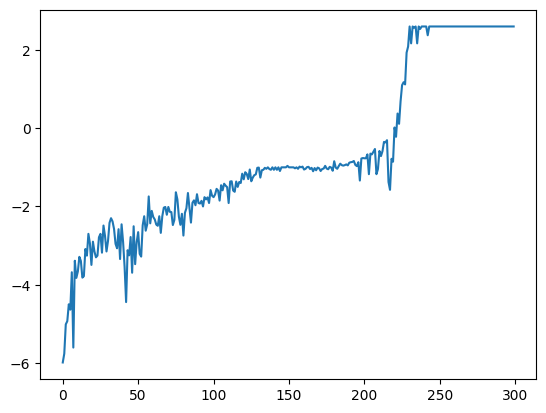

In [325]:
batch_size = 16

# torch.manual_seed(0)
model = Policy(env.num_node_types, env.num_edge_types, emb_dim=32, num_layers=3)
optimizer = torch.optim.Adam(model.parameters())

avg_rewards = []
pbar = tqdm.trange(300)
for _ in pbar:
    trajectories = sample_trajectories(env, model, batch_size)
    log_probs = get_trajectory_log_probs(model, trajectories)
    rewards = torch.tensor(
        [reward_func(t.last_state) for t in trajectories]).float()
    
    loss = torch.mean(- log_probs * rewards)
    optimizer.zero_grad()
    loss.backward()
    
    nn.utils.clip_grad_norm_(
        model.parameters(), 0.5)
    optimizer.step()
    
    avg_rewards.append(rewards.mean().item())
    
    pbar.set_postfix({"avg_reward": avg_rewards[-1]})
    
    
plt.plot(avg_rewards)
plt.show()

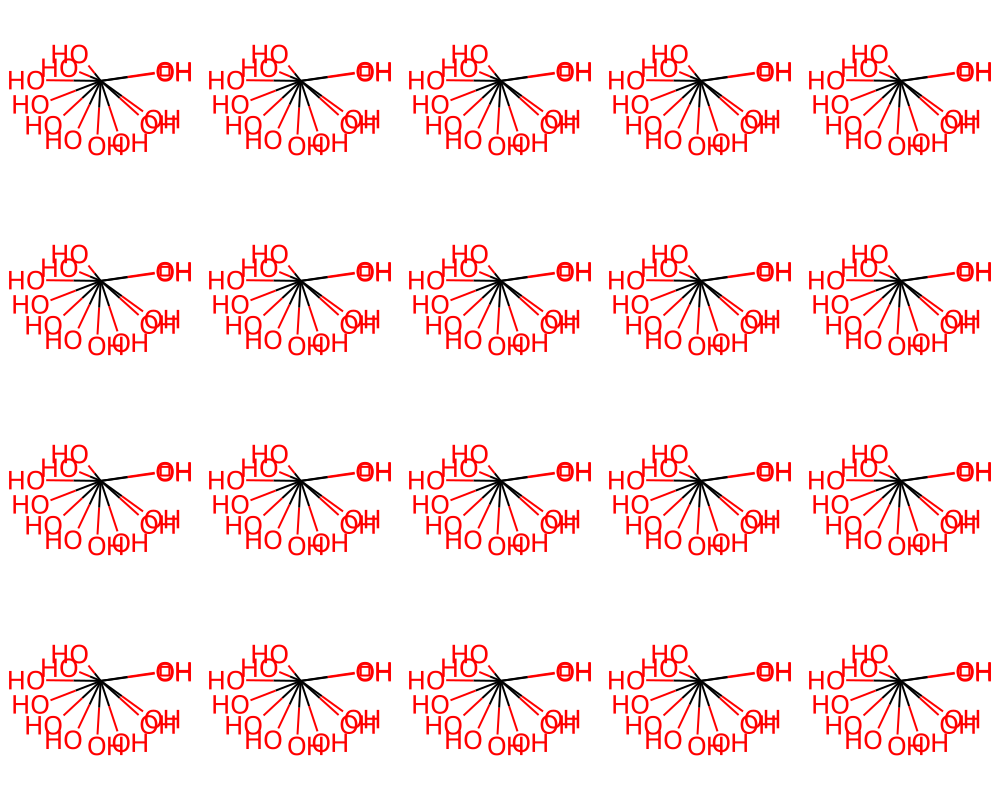

In [326]:
trajs = sample_trajectories(env, model, 20)
samples = [t.last_state.to_mol() for t in trajs]

Chem.Draw.MolsToGridImage(samples, molsPerRow=5)